This notebook is an adaptation of previous joint work with Karen Ertrachter, Tuba Kestin, and Michael Hauser. Much of this work was originally performed in R. I reworked this project as a means of getting practice with some graph packages in Python. I also used the messaging metadata to build a recommender system which is created at the end of this notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import networkx as nx
from nxviz import CircosPlot
import random

from collections import defaultdict
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv("CityAunrecMW.csv", low_memory=False)

In [3]:
print(len(df))
list(df)

143028


['senderid',
 'receiverid',
 'timestamp',
 'nway',
 'msgs_sender',
 'msgs_receiver',
 'sender_gender',
 'sender_essays',
 'sender_sfriends',
 'sender_ltd',
 'sender_std',
 'sender_activity',
 'sender_penpal',
 'sender_casual',
 'sender_age',
 'sender_educ',
 'sender_HSless',
 'sender_somecol',
 'sender_college',
 'sender_grad',
 'sender_student',
 'sender_drinks',
 'sender_race',
 'sender_relig',
 'sender_bodytype',
 'sender_smokes',
 'sender_children',
 'sender_lowage',
 'sender_highage',
 'sender_Group',
 'sender_attractive',
 'receiver_gender',
 'receiver_photos',
 'receiver_essays',
 'receiver_sfriends',
 'receiver_ltd',
 'receiver_std',
 'receiver_activity',
 'receiver_penpal',
 'receiver_casual',
 'receiver_age',
 'receiver_educ',
 'receiver_HSless',
 'receiver_somecol',
 'receiver_college',
 'receiver_grad',
 'receiver_student',
 'receiver_drinks',
 'receiver_race',
 'receiver_relig',
 'receiver_bodytype',
 'receiver_smokes',
 'receiver_children',
 'receiver_lowage',
 'receiver_

In this data set, all of the messages originated from men. This is confirmed by the cell below. The value 0 corresponds to males and the value 1 corresponds to females.

In [4]:
df.sender_gender.value_counts()

0    143028
Name: sender_gender, dtype: int64

Most of the messages from the men were sent to female users, as the cell below confirms.

In [5]:
df.receiver_gender.value_counts()

1    142968
0        60
Name: receiver_gender, dtype: int64

Since there are very few messages from men to other men, we elect to drop these from our analysis for the remainder of this investigation.

In [6]:
df = df[df.receiver_gender == 1]

In [7]:
# redo this with column as datetime object
df['timestamp'] = pd.to_datetime(df.timestamp, infer_datetime_format=True)

end_date = df.timestamp.max()
start_date = df.timestamp.min()
print("Messaging data was collected from {0} until {1}.".format(start_date.date(), end_date.date()))

Messaging data was collected from 2010-09-09 until 2011-03-23.


This lets us know our data was collected over about six and a half months.

In [8]:
df.nway.value_counts(1)

1    0.779916
3    0.180502
2    0.039582
Name: nway, dtype: float64

The **nway** column encodes information about whether or not the sender's message was responded to by the receiver. A value of 1 indicates that the message was ignored. A value of 2 indicates that the receiver replied to the message, but the original sender did not reply to that message. A value of 3 indicates that the receiver replied to the message and the sender sent at least one more message back to the receiver. Thus, the above calculation shows us the following summary information.
* 78% of messages received no response from the recipient.
* 18% of messages received a response from the woman; however, the man did not continue the conversation as a result.
* 4% of messages sent actually started some sort of conversation.

We can first figure out the number of users (senders and receivers) contained in this data set.

In [9]:
senders = set(df.senderid)
receivers = set(df.receiverid)
num_users = len(senders.union(receivers))
print("We have message data for {} distinct users.".format(str(num_users)))
print("{} users sent messages on the platform.".format(str(len(senders))))
print("{} users received messages on the platform.".format(str(len(receivers))))

We have message data for 8791 distinct users.
4341 users sent messages on the platform.
4450 users received messages on the platform.


Let's investigate the age differences between message senders and receivers.

count    142968.000000
mean          2.306635
std           5.685558
min         -44.000000
25%           0.000000
50%           2.000000
75%           5.000000
max          42.000000
Name: age_difference, dtype: float64

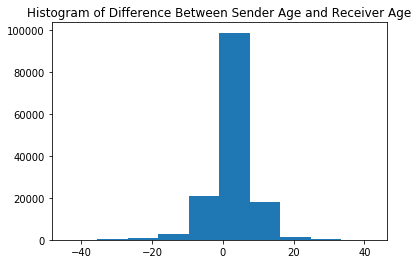

In [10]:
df['age_difference'] = df.sender_age - df.receiver_age
plt.hist(df.age_difference)
plt.title("Histogram of Difference Between Sender Age and Receiver Age")
df.age_difference.describe()

On average, men send message to women who are about 2 years younger than them. There was one man who messaged someone 42 years younger than him and one man who messaged someone 44 years older than him. Only 25% of messages were sent to women older than the sender.

Let's perform the same analysis based on the difference in attractiveness ratings between the men and women.

count    142968.000000
mean         -1.035857
std           0.686833
min          -3.632700
25%          -1.511725
50%          -1.027200
75%          -0.608700
max           3.232800
Name: attractive_difference, dtype: float64

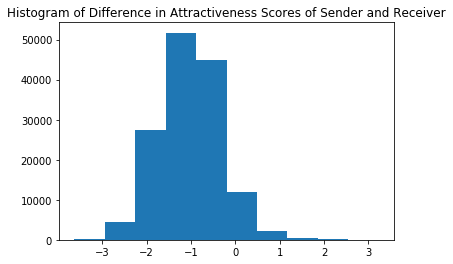

In [11]:
df['attractive_difference'] = df.sender_attractive - df.receiver_attractive
plt.hist(df.attractive_difference)
plt.title("Histogram of Difference in Attractiveness Scores of Sender and Receiver")
df.attractive_difference.describe()

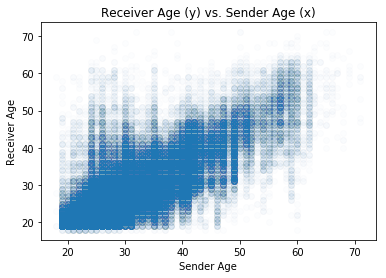

In [12]:
plt.scatter(df.sender_age, df.receiver_age, alpha = 0.01)
plt.xlabel("Sender Age")
plt.ylabel("Receiver Age")
plt.title("Receiver Age (y) vs. Sender Age (x)")
plt.show()

From the scatter plot above, it appears that women tend to receive messages from men of a fairly wide age range, while men send messages to women in narrower age ranges. We can make this more statistically rigorous with a bit of linear regression analysis. TBA.

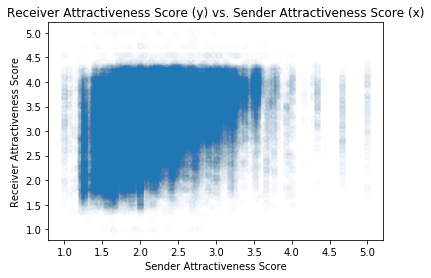

In [13]:
plt.scatter(df.sender_attractive, df.receiver_attractive, alpha = 0.01)
plt.xlabel("Sender Attractiveness Score")
plt.ylabel("Receiver Attractiveness Score")
plt.title("Receiver Attractiveness Score (y) vs. Sender Attractiveness Score (x)")
plt.show()

We see that on average the women receiving messages were typically of a higher attractiveness rating (by about 1.5 standard deviations) than the men messaging them. Let's investigate how the distribution of attractiveness scores compare for men and women.


In [14]:
df.sender_attractive.describe()

count    142968.000000
mean          2.210457
std           0.545218
min           1.000000
25%           1.811000
50%           2.154800
75%           2.516700
max           5.000000
Name: sender_attractive, dtype: float64

In [15]:
df.receiver_attractive.describe()

count    142968.000000
mean          3.246314
std           0.622821
min           1.000000
25%           2.840400
50%           3.326200
75%           3.741500
max           5.000000
Name: receiver_attractive, dtype: float64

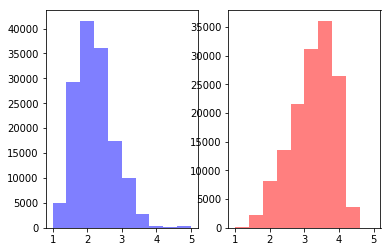

In [16]:
fig, ax = plt.subplots(1,2)

ax[0].hist(df.sender_attractive, alpha=0.5, label='M', color='b')
ax[1].hist(df.receiver_attractive, alpha=0.5, label='F', color='r')
plt.show()

From the analysis above, we see that the men have overall lower attractiveness scores than the women. We will confirm the statistical significance of this observation rigorously below by using Welch's t-test. It should be noted that this histogram is based on treating each message as a statistical unit. This point will be revisited later in the kernel when we begin analyzing the data through a bipartite graph.

In [17]:
t = ttest_ind(df.sender_attractive, df.receiver_attractive, equal_var=False)
print(t)

Ttest_indResult(statistic=-473.1734313519654, pvalue=0.0)


The p-value of 0.0 supports our previous observation. We can now standardize each column and see whether or not standardizing the distributions to account for the differences in scoring by men and women accounts for the tendency of men to send messages to women who have higher attractiveness ratings than they do.

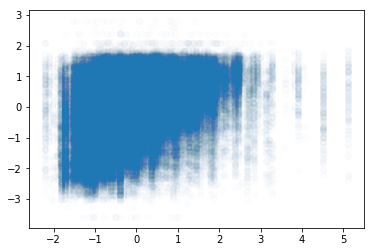

In [18]:
df['sender_attractive_normalized'] = (df.sender_attractive - df.sender_attractive.mean()) / df.sender_attractive.std()
df['receiver_attractive_normalized'] = (df.receiver_attractive - df.receiver_attractive.mean()) / df.receiver_attractive.std() 

plt.scatter(df.sender_attractive_normalized, df.receiver_attractive_normalized, alpha = 0.01)
plt.show()

Although this graph has the same shape, standardization seems to have greatly reduced the gap in attractiveness scores between senders and receivers. This can be confirmed with the calculations performed below.

count    1.429680e+05
mean    -4.802388e-14
std      1.171100e+00
min     -4.362171e+00
25%     -8.023222e-01
50%      1.934266e-02
75%      7.118319e-01
max      7.491240e+00
Name: normalized_attractive_difference, dtype: float64

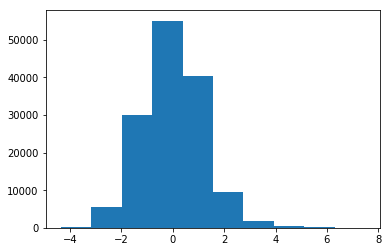

In [19]:
df['normalized_attractive_difference'] = df.sender_attractive_normalized - df.receiver_attractive_normalized
plt.hist(df.normalized_attractive_difference)
df.normalized_attractive_difference.describe()

We can represent the messaging schemes as a bipartite graph with senders (men) in one partition and receivers (women) in the other partition. In the remainder of this kernel, we will focus on applying graph theory to this data set for the purposes of building a recommender system that suggests profiles the sender may want to message. To start, we need to build a bipartite graph from this data set. One partition will contain the senders (men) and the other will contain the receivers (women).

In [20]:
G = nx.Graph()
G.add_nodes_from(df.senderid, bipartite='sender')
G.add_nodes_from(df.receiverid, bipartite='receiver')
G.add_edges_from(zip(df.senderid, df.receiverid))
nx.is_bipartite(G) # verifies that created graph is bipartite

True

The degree centrality of a node is defined to be the number of neighbors of that node divided by the total number of neighbors that node could have. For a sender node, the denominator would equal the total number of receiver nodes. Likewise, for a receiver node, the denominator would be the total number of sender nodes. Degree centrality of a sender node tells us what fraction of the receivers that particular user has messaged and for a receiver node the degree centrality tells us what fraction of the senders have messaged that receiver.

In [21]:
def get_nodes_from_partition(G, partition):
    """
    Returns a list of all nodes from G belong to the specified partition.
    
    Args:
        G - a networkx Graph object, assumed to be a bipartite graph
            NB: we assume the metadata 'bipartite' is correctly assigned
            to nodes in this graph
        partition - a value corresponding to one of the two partitions of
            nodes in the bipartite graph.
            
    Output:
        a list of nodes belonging to the specified partition
    """
    return [n for n in G.nodes() if G.node[n]['bipartite'] == partition]


Number of sender nodes: 4341
Number of receiver nodes: 4450
count    8791.000000
mean        0.007401
std         0.011166
min         0.000225
25%         0.001573
50%         0.004045
75%         0.008989
max         0.224270
dtype: float64


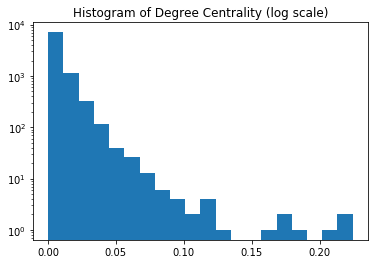

In [22]:
sender_nodes = get_nodes_from_partition(G, 'sender')
receiver_nodes = get_nodes_from_partition(G, 'receiver')

print("Number of sender nodes: " + str(len(sender_nodes)))
print("Number of receiver nodes: " + str(len(receiver_nodes)))

deg_centrality = nx.bipartite.degree_centrality(G, sender_nodes)

deg_centrality_series = pd.Series(list(deg_centrality.values()))

print(deg_centrality_series.describe())

plt.yscale('log')
plt.hist(deg_centrality_series, bins=20)
plt.title("Histogram of Degree Centrality (log scale)")
plt.show()

The statistics presented in the cell above do not separate the sender and receiver nodes from the bipatrite graph. We separate the partiions below and compute summary statistics for each partition along with plotting logarithmically scaled histograms for the degree centrality.

Summary Statistics for Sender Degree Centralities:
count    4341.000000
mean        0.007401
std         0.013775
min         0.000225
25%         0.001124
50%         0.003146
75%         0.007640
max         0.224270
dtype: float64

Summary Statistics for Receiver Degree Centralities
count    4450.000000
mean        0.007401
std         0.007825
min         0.000230
25%         0.002073
50%         0.004838
75%         0.009906
max         0.077632
dtype: float64


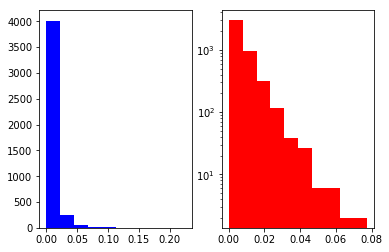

In [23]:
receiver_dcs = [deg_centrality[n] for n in receiver_nodes]
sender_dcs = [deg_centrality[n] for n in sender_nodes]

print("Summary Statistics for Sender Degree Centralities:")
print(pd.Series(sender_dcs).describe())
print()
print("Summary Statistics for Receiver Degree Centralities")
print(pd.Series(receiver_dcs).describe())

fig, ax = plt.subplots(1,2)

plt.yscale('log')
ax[0].hist(sender_dcs, label='Sender', color='b')
ax[1].hist(receiver_dcs, label='Receiver', color='r')
plt.show()

From the summary statistics, we can see that men sent a median of 14 messages to different women on the platform. Note the distribution of sender degree centralities is skewed right and that one user messaged around 22.5% of the women on the site! This suggests that the earlier comparison of attractiveness distributions of senders and receivers was not exactly correct. The rows in our original data frame corresponded to messages rather than users. A more appropriate comparison of the distributions of sender and receiver attractiveness would count each sender and each receiver only once.

We will first create scatter plots to invesitgate the relationship between degree centrality and attractiveness scores. We will then remake the histograms presnted earlier by averaging creating a series that only counts each users' attractiveness score once per user rather than once per message. This will give a better indication of how attractiveness ratings vary between senders (males) and receivers (females).

Summary Statistics for Sender Attractiveness Score: 
count    4341.000000
mean        2.229165
std         0.580444
min         1.000000
25%         1.789500
50%         2.154800
75%         2.588200
max         5.000000
dtype: float64

Summary Statistics for Receiver Attractiveness Score:
count    4450.000000
mean        2.861095
std         0.711920
min         1.000000
25%         2.289775
50%         2.884250
75%         3.426325
max         5.000000
dtype: float64


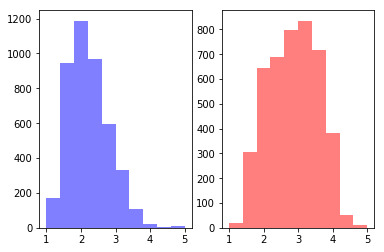

In [24]:
temp = df.groupby(by=['senderid']).sender_attractive.mean()
sender_attractive_series = pd.Series([temp[n] for n in sender_nodes])

temp = df.groupby(by=['receiverid']).receiver_attractive.mean()
receiver_attractive_series = pd.Series([temp[n] for n in receiver_nodes])

print("Summary Statistics for Sender Attractiveness Score: ")
print(sender_attractive_series.describe())
print()
print("Summary Statistics for Receiver Attractiveness Score:")
print(receiver_attractive_series.describe())

fig, ax = plt.subplots(1,2)

ax[0].hist(sender_attractive_series, alpha=0.5, label='M', color='b')
ax[1].hist(receiver_attractive_series, alpha=0.5, label='F', color='r')
plt.show()

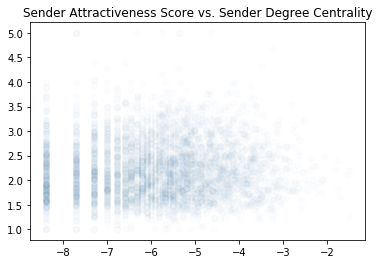

In [25]:
plt.title("Sender Attractiveness Score vs. Sender Degree Centrality")
plt.scatter([math.log(s) for s in sender_dcs], sender_attractive_series, alpha = 0.01)
plt.show()

There doesn't appear to be much of a relationship between the attractiveness of the sender and the percentage of users that he messages.

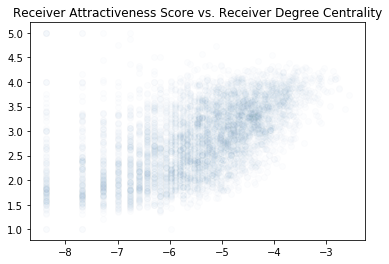

In [26]:
plt.title("Receiver Attractiveness Score vs. Receiver Degree Centrality")
plt.scatter([math.log(s) for s in receiver_dcs], receiver_attractive_series, alpha = 0.01)
plt.show()

However, the above plot indicates a positive relationship between receiver attractiveness and the number of messages she receives.

In order to build a recommender system based on this bipartite graph, we need to write a few functions which will allow us to look at and quantify the similarities between the senders' messages.


In [27]:
def shared_partition_nodes(G, node1, node2):
    """
    Returns the nodes which are neighbors of both node1 and node2
    
    Args:
        G - a networkx graph object
        node1 - a networkx node belonging to G
        node2 - a networkx node belonging to G
        
    Output:
        a set of nodes belonging to the other partition of the bipartite
        graph which are neighbors of both node1 and node2.
    """
    assert G.node[node1]['bipartite'] == G.node[node2]['bipartite']

    nbrs1 = G.neighbors(node1)
    nbrs2 = G.neighbors(node2)

    return set(nbrs1).intersection(nbrs2)

def node_similarity(G, sender1, sender2, receiver_nodes):
    """
    Returns a measure of the similarity between the nodes sender1 and sender2.
    
    Args:
        G - a networkx Graph object representing a bipartite graph
        sender1 - a node in G belonging to the same partition as sender2
        sender2 - a node in G belonging to the same partition as sender1
        receiver_nodes - a list of nodes in the other partition of the bipartite graph G
        
    Output:
        a number between 0 and 1 representing the fraction of the total possible neighbors
        that the nodes sender1 and sender 2 share.
    """
    assert G.node[sender1]['bipartite'] == 'sender'
    assert G.node[sender2]['bipartite'] == 'sender'

    shared_nodes = shared_partition_nodes(G, sender1, sender2)

    return len(shared_nodes) / len(receiver_nodes)

def most_similar_users(G, user, user_nodes, receiver_nodes):
    """
    Returns a list of users with the highest similarity score to user.
    
    Args:
        G - a networkx Graph object representing a bipartite graph
        user - the node for which we want to find the most similar users
        user_nodes - a list containing the other nodes in the same partition as the user node
        receiver_nodes - a list of nodes in the other partition
        
    Output:
        a list of users with the highest similarity score to user
    """
    assert G.node[user]['bipartite'] == 'sender'

    user_nodes = set(user_nodes)
    user_nodes.remove(user)

    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = node_similarity(G, user, n, receiver_nodes)
        similarities[similarity].append(n)

    max_similarity = max(similarities.keys())

    return similarities[max_similarity]

def suggest_receiver(G, from_user, to_user):
    """
    Returns the set of all neighbors of from_user which are not neighbors of to_user.
    
    Args:
        G - a networkx Graph object representing a bipartite graph
        from_user - the user we are recommending from
        to_user - the user we are recommending to
        
    Outputs:
        a set of nodes representing the neighbors of from_user which are not neighbors
        of to_user. If this set is empty, returns the set of all non-neighbors of the
        to_user. If to_user is neighbors with all possible nodes, it returns the set of
        all nodes.
    """
    from_receivers =  set(G.neighbors(from_user))
    to_receivers = set(G.neighbors(to_user))
    suggestions = from_receivers.difference(to_receivers)
    backup = set(receiver_nodes).difference(to_receivers)
    if suggestions:
        return suggestions
    elif backup: # if intersected set is empty, return receivers the user hasn't messaged
        return backup
    else: #only if user has messaged every possible receiver
        return set(receiver_nodes)

def recommend(G, user, sender_nodes, receiver_nodes):
    """
    Recommends a profile for user to try messaging.
    """
    most_similar = most_similar_users(G, user, sender_nodes, receiver_nodes)
    if most_similar:
        node2 = random.choice(most_similar)
    else:
        node2 = rando.choice(sender_nodes)
    return random.choice(list(suggest_receiver(G, user, node2)))

In [28]:
user = random.choice(sender_nodes)
print(user)
most_sim = most_similar_users(G, user, sender_nodes, receiver_nodes)
print(most_sim)
suggest_receiver(G, user, random.choice(most_sim))

print(recommend(G, user, sender_nodes, receiver_nodes))

1400
[811, 2921]
2979
